In [1]:
import os
import keras.backend as K
import numpy as np
from keras.layers import Dense
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.core import Flatten
from keras.layers import Input
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.models import Model
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.applications.vgg19 import VGG19
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.optimizers import Adam
from keras.layers import add, Concatenate, Lambda
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from skimage.transform import rescale, resize
from skimage import io
from scipy.misc import imresize
from skimage import data
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from PIL import Image
# %%capture
from tqdm import tqdm_notebook as tqdm
from time import sleep
tqdm().pandas()

Using TensorFlow backend.


In [7]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
# Load the Drive helper and mount
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Network Architecture
![title](network.jpg)

The modified architecture consists of:

    1. Conv2d (k9n64s1), followed by PReLU
    2. 16 basic residual blocks are replace with Inception A module consisting of Conv2d, BN, PReLU with three braches of 1, 3 and modified 5 kernel
    3. Another copnv2d, BN and element wise sum
    4. 2 upsample blocks consisting of deconvolution 
    4. One last conv layer k9n3s1
    5. Activated on say 'tan'

We will code this generator for the default implementation


In [ ]:
def gen_res_blocks(m, k, f, s):
    gen = m
    
    m = Conv2D(filters = f, kernel_size = k, strides = s, padding='same')(m)
    m = BatchNormalization(momentum = 0.5)(m)
    
    #using PReLU
    m = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(m)
    m = Conv2D(filters = f, kernel_size= k, strides = s, padding='same')(m)
    
    m = BatchNormalization(momentum = 0.5)(m)
    
    m = add([gen, m])
    
    return m
  
# here we begin
def conv2d_bn(x, filters, kernel_size, strides=1, padding='same', activation='PReLU', use_bias=False, name=None):
    # conv layer
    x = Conv2D(filters, kernel_size, strides=strides,padding=padding,use_bias=use_bias)(x)
    # followed by batch normalization
    if not use_bias:
        bn_axis = 1 if K.image_data_format() == 'channels_first' else 3
#         bn_name = _generate_layer_name('BatchNorm', prefix=name)
        x = BatchNormalization(axis=bn_axis, scale=False, momentum=0.5)(x)
#     x = BatchNormalization(momentum=0.5)(x)
    if activation is not None:
        x = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(x)
        
    return x

def inception_resnet_module(x, scale, c_axis, activation='relu'):
    
    # defining all branches of our inception module
    branch_0 = conv2d_bn(x, 32, 1)
    branch_1 = conv2d_bn(x, 32, 1)
    branch_1 = conv2d_bn(branch_1, 32, 3)
    branch_2 = conv2d_bn(x, 32, 1)
    branch_2 = conv2d_bn(branch_2, 48, 3)
    branch_2 = conv2d_bn(branch_2, 64, 3)
    
    branches = [branch_0, branch_1, branch_2]
    
    # concatenating our branches
    mixed = Concatenate(axis=c_axis)(branches)
    
    up = conv2d_bn(mixed, K.int_shape(x)[c_axis], 1, activation=None, use_bias=True)
    
    x = Lambda(lambda inputs, scale: inputs[0] + inputs[1] * scale,
               output_shape=K.int_shape(x)[1:], arguments={'scale': scale})([x, up])
    
    x = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(x)
    
    return x

def gen_upsampling_block(m, k, f, s):
    m = Conv2D(filters=f, kernel_size=k, strides=s, padding='same')(m)
    m = UpSampling2D(size = 2)(m)
    m = LeakyReLU(alpha=0.2)(m)
    
    return m

def create_generator(noise_shape):
    gen_input = Input(shape=noise_shape)
    
    model = Conv2D(filters=64, kernel_size=9, strides=1, padding='same')(gen_input)
    
    model = PReLU(alpha_initializer='zeros', alpha_regularizer=None, alpha_constraint=None, shared_axes=[1,2])(model)
    
    gen_model = model
    
    channel_axis = 1 if K.image_data_format() == 'channels_first' else 3
    # 16 residual blocks
    for i in range(16):
        model = inception_resnet_module(model, scale=0.17, c_axis=channel_axis) 
#         model = gen_res_blocks(model, 3, 64, 1)
            
    
    model = Conv2D(filters = 64, kernel_size = 3, strides=1, padding='same')(model)
    model = BatchNormalization(momentum=0.5)(model)
    model = add([gen_model, model])
    
    # 2 upsampling blocks
    for i in range(2):
        model = gen_upsampling_block(model, 3, 256, 1)
        
    # final conv layer
    model = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(model)
    model = Activation('tanh')(model)
    
    generator_model = Model(inputs = gen_input, output = model)
    
    return generator_model

In [ ]:
model = create_generator((56,56,3))
display(model.summary())
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

In [ ]:
## discrtiminator network

def get_dis_block(m, f, k, s):
    m = Conv2D(filters=f, kernel_size=k, strides=s, padding='same')(m)
    m = BatchNormalization(momentum=0.5)(m)
    m = LeakyReLU(alpha=0.2)(m)
    
    return m
    


def create_discriminator(image_shape):
    dis_input = Input(shape=image_shape)
    
    model = Conv2D(filters = 64, kernel_size = 3, strides = 1, padding = "same")(dis_input)
    model = LeakyReLU(alpha = 0.2)(model)
    
    model = get_dis_block(model, 64, 3, 2)
    model = get_dis_block(model, 128, 3, 1)
    model = get_dis_block(model, 128, 3, 2)
    model = get_dis_block(model, 256, 3, 1)
    model = get_dis_block(model, 256, 3, 2)
    model = get_dis_block(model, 512, 3, 1)
    model = get_dis_block(model, 512, 3, 2)
    
    model = Flatten()(model)
    model = Dense(1024)(model)
    model = LeakyReLU(alpha=0.2)(model)
    
    model = Dense(1)(model)
    model = Activation('sigmoid')(model)
    
    discriminator_model = Model(inputs = dis_input, outputs = model)
    
    return discriminator_model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 224, 224, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)      256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 112, 112, 64)      0         
_________________________________________________________________
conv

None

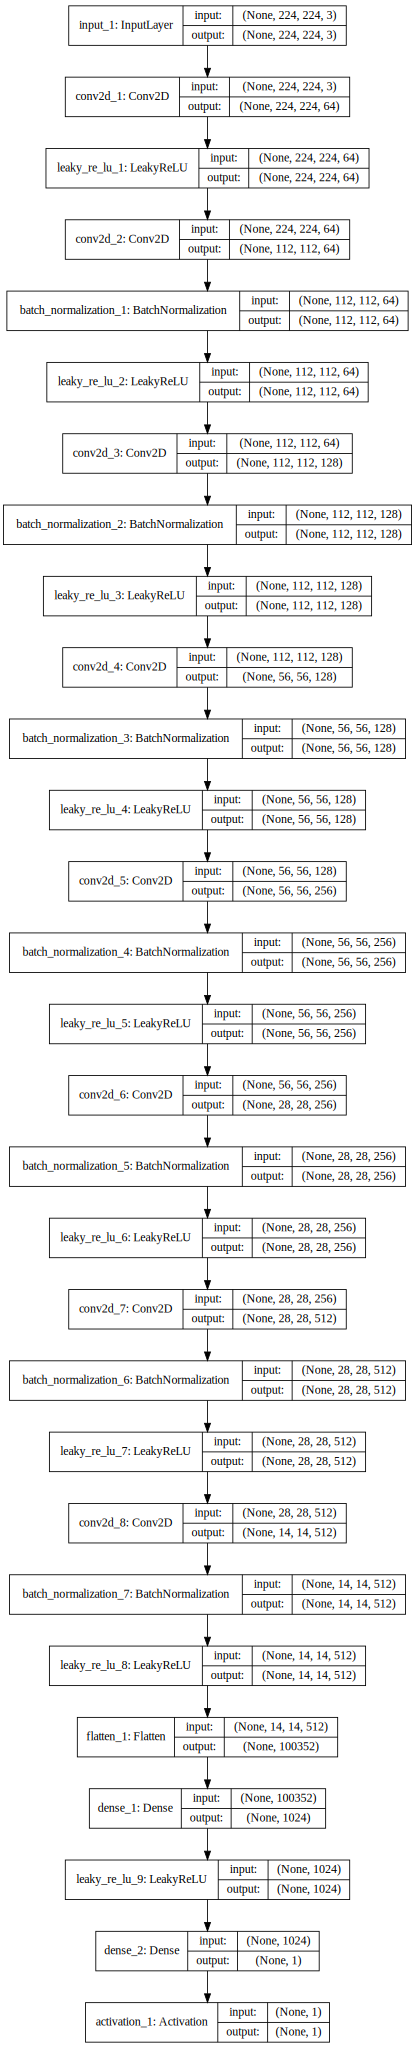

In [5]:
dis_model = create_discriminator((224,224,3))
display(dis_model.summary())
SVG(model_to_dot(dis_model, show_layer_names=True, show_shapes=True, rankdir='TB').create(prog='dot', format='svg'))

In [ ]:
import zipfile
# unzip images
if not os.path.isdir("data"):
  os.mkdir('data')

if not os.path.isdir("gen_samples"):
  os.mkdir('gen_samples')

# if not os.path.isdir("drive/My Drive/Colab Notebooks/AML_SR_GAN"):
#   os.mkdir('drive/My Drive/Colab Notebooks/AML_SR_GAN')
zip_ref_1 = zipfile.ZipFile("drive/My Drive/Colab Notebooks/AML_SR_GAN/train_imgs1.zip", 'r')
zip_ref_2 = zipfile.ZipFile("drive/My Drive/Colab Notebooks/AML_SR_GAN/train_imgs2.zip", 'r')
zip_ref_1.extractall('data')
zip_ref_2.extractall('data')
zip_ref_1.close()
zip_ref_2.close()

# UTILITY METHODS

In [ ]:
def normalize(input_data):
    return (input_data.astype(np.float32) - 127.5)/127.5 

def denormalize(input_data):
    input_data = (input_data + 1) * 127.5
    return input_data.astype(np.uint8)

def get_images(img_dir, train_test_ratio, number_images):
    # load all images from the img_dir
    hr, lr = [], []
    images = []
    count = 1
    for f in os.listdir(img_dir):
        if os.path.isfile(os.path.join(img_dir, f)):
            # reads img file as numpy array
            img = data.imread(os.path.join(img_dir, f))
            # resize iamge to 224, 224 after checking it is larger than or queal to 224,224
            images.append(img)
        
        if count == number_images:
            break
        else:
            count += 1
            
    # shuffle images
    images = shuffle(images)
    
    
    for img in images:
      if img.shape[0] >= 224 and img.shape[1] >= 224:
        img_hr = imresize(img, [224, 224], interp='bicubic', mode=None)
        img_lr = imresize(img_hr, [img_hr.shape[0]//4, img_hr.shape[1]//4], interp='bicubic', mode=None)

        hr.append(img_hr)
        lr.append(img_lr)
        
        
    # split the images into train and test
    hr_norm = normalize(np.array(hr))
    lr_norm = normalize(np.array(lr))
    partition_index = int(len(hr) * train_test_ratio)
    test_hr, train_hr = hr_norm[:partition_index], hr_norm[partition_index:]
    test_lr, train_lr  = lr_norm[:partition_index], lr_norm[partition_index:]
    
    return np.array(train_hr), np.array(train_lr), np.array(test_hr), np.array(test_lr)

    
def plot_generated_image(img_hr, img_lr, save_dir, generator, epoch):
    
    gen_image = generator.predict(img_lr)
    
    # pick a random image to show
    rand_ind = np.random.randint(0, img_hr.shape[0])
    
    # may need to denromalize images here
    img_hr_de, img_lr_de = denormalize(img_hr), denormalize(img_lr)
    gen_image_de = denormalize(gen_image)
    
  
    dim = (1, 3)
    plt.figure(figsize=(10, 10))
    
    ax0 = plt.subplot(dim[0], dim[1], 1)
    ax0.set_title('LR Image')
    io.imshow(img_lr_de[rand_ind])
    plt.axis('off')
        
    ax1 = plt.subplot(dim[0], dim[1], 2)
    ax1.set_title('SR Gan Image')
    io.imshow(gen_image_de[rand_ind])
    plt.axis('off')
    
    ax2 = plt.subplot(dim[0], dim[1], 3)
    ax2.set_title('HR Image')
    io.imshow(img_hr_de[rand_ind])
    plt.axis('off')
    
    plt.tight_layout()
    plt.savefig(save_dir + '/generated_image_%d.png' % epoch)
    plt.show()
    
    

def plot_all_images(generator, save_dir, 
                    test_images=None, img_dir=None):
  
  # make saving dir if it does not exist
  if not os.path.isdir(save_dir):
    os.mkdir(save_dir)
  
  if img_dir is not None:
    img_count = 0
    lr = []
    hr = []
    for f in os.listdir(img_dir):
      if os.path.isfile(os.path.join(img_dir, f)):
        img = data.imread(os.path.join(img_dir, f))
        # chekc if we have hr image
        if img.shape[0] >= 224 and img.shape[1] >= 224:
          hr.append(img)
        # resize to low res just in case
        img_lr = imresize(img, [56, 56], interp='bicubic', mode=None)
        lr.append(img_lr)
        img_count += 1
    print(img_count, ' images read from: ', img_dir)
    # plotting the lr and gen sr image:
    
    # denormalizing the shape
    lr_norm = normalize(np.array(lr))
    sr_im = generator.predict(lr_norm)
    sr_im_de = denormalize(sr_im)
    
    #we have same number of hr and lr images otherwise plotting code will break
    if len(hr) == len(lr):
      hr_norm = np.array(hr)
      print(hr_norm.shape)
    
    for i, im in enumerate(lr):
      
      if hr_norm is None:
        dim = (1, 2)
      else:
        dim = (1, 3)
      
      plt.figure(figsize=(10, 10))
      
      ax0 = plt.subplot(dim[0], dim[1], 1)
      ax0.set_title('LR Image')
      io.imshow(im)
      plt.axis('off')
      
      ax1 = plt.subplot(dim[0], dim[1], 2)
      ax1.set_title('SR Gan Image')
      
      # saving the generated images separately as well
      im = Image.fromarray(sr_im_de[i])
      im.save(save_dir + "/single_gen_img_{0}.jpg".format(i))
      
      io.imshow(sr_im_de[i])
      plt.axis('off')
      
      if dim[1] == 3:
        # we have hr image as well
        ax2 = plt.subplot(dim[0], dim[1], 3)
        ax2.set_title('HR Image')
        io.imshow(hr_norm[i])
        plt.axis('off')
      
      plt.tight_layout()
      plt.savefig(save_dir + '/generated_image_%d.png' % i)
      plt.show()
      
      
      
      
  elif test_images is not None:
    print('We have the test images passed in rather than the dir')
    hr, lr = test_images[0], test_images[1]
    # assuming the lr and hr images passed are normalized
    gen_image = generator.predict(lr)
    # denormalizing the images
    img_hr_de, img_lr_de, gen_image_de = denormalize(hr), denormalize(lr), denormalize(gen_image)
    img_index = 0
    for h_img, l_img, sr_img in zip(img_hr_de, img_lr_de, gen_image_de):
      
      dim = (1, 3)
      plt.figure(figsize=(10, 10))
    
      ax0 = plt.subplot(dim[0], dim[1], 1)
      ax0.set_title('LR Image')
      io.imshow(l_img)
      
      plt.axis('off')
        
      ax1 = plt.subplot(dim[0], dim[1], 2)
      ax1.set_title("SR Gan Image")
      io.imshow(sr_img)
      
      plt.axis('off')
    
      ax2 = plt.subplot(dim[0], dim[1], 3)
      ax2.set_title("HR Image")
      io.imshow(h_img)
      
      plt.axis('off')
    
      plt.tight_layout()
      plt.savefig(save_dir + '/generated_image_%d.png' % img_index)
    
      # saving the image separately as well
      im = Image.fromarray(sr_img)
      im.save(save_dir + "/single_gen_img_{0}.jpg".format(img_index))
      plt.show()
      
      
      img_index += 1
      

# Inception Resnet V2 LOSS


*   Instead of VGG, I extract ferature from block35 and 5th conv2_bn block after convolution and before activation

* as you'' see this is giving blurry images



In [ ]:
# from keras.applications.vgg19 import VGG19
# import keras.backend as K
# from keras.models import Model
# from keras.optimizers import Adam

def inception_resnet_loss(y_true, y_pred):
    
    image_shape = (224, 224, 3)
    
    irv2 = InceptionResNetV2(include_top=False, weights='imagenet', input_shape=image_shape)
    irv2.trainable = False
    
    # freeze each layer in 
    for l in irv2.layers:
        l.trainable = False
    model = Model(inputs=irv2.input, outputs=irv2.get_layer('block35_5_conv').output)
#     model = Model(inputs=irv2.input, outputs=irv2.get_layer('mixed_5b').output)
    model.trainable = False
    
    return K.mean(K.square(model(y_true) - model(y_pred)))

# TRAINING

In [ ]:
# def get_gan_network(dis_m, gen_m, ):

def get_gan_network(dis_m, gen_m, shape, opt, content_loss):
    dis_m.trainable = False
    gan_input = Input(shape=shape)
    x = gen_m(gan_input)
    gan_output = dis_m(x)
    
    gan = Model(inputs=gan_input, outputs=[x, gan_output])
    
    gan.compile(loss=[content_loss, 'binary_crossentropy'], loss_weights=[1, 1e-3], optimizer=opt)
    
    return gan

def train(epochs, batch_size, dataset, save_dir, dis_model_path=None, gen_model_path=None):
    
    x_tr_hr, x_tr_lr, x_test_hr, x_test_lr = dataset[0], dataset[1], dataset[2], dataset[3]
    lr_factor = 4
    
    image_shape_hr = (224, 224, 3)
    image_shape_lr = (image_shape_hr[0]/lr_factor, image_shape_hr[0]/lr_factor, image_shape_hr[2])
    
    generator = create_generator(image_shape_lr)
    if gen_model_path is not None and os.path.isfile(gen_model_path):
      print('Generator weights updated')
      generator.load_weights(gen_model_path)
      
    discriminator = create_discriminator(image_shape_hr)
    if dis_model_path is not None and os.path.isfile(dis_model_path):
      print('Dis model weights updated')
      discriminator.load_weights(dis_model_path)
    
    
    opt = Adam(lr=1E-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    
    generator.compile(loss=inception_resnet_loss, optimizer=opt)
    discriminator.compile(loss="binary_crossentropy", optimizer=opt)
    
    gan = get_gan_network(discriminator, generator, image_shape_lr, opt, inception_resnet_loss)
    
    
    batch_count = int(len(x_tr_hr)/batch_size)
    for e in range(1, epochs+1):
        print ('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(batch_count)):
          
            # training the discriminator first
            rand_nums = np.random.randint(0, x_tr_hr.shape[0], size=batch_size)
            batch_hr = x_tr_hr[rand_nums]
            batch_lr = x_tr_lr[rand_nums]
            gen_im_sr = generator.predict(batch_lr)
            
            real_im_y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            fake_im_y = np.random.random_sample(batch_size)*0.2
            
            discriminator.trainable = True
            
            real_im_dis_loss = discriminator.train_on_batch(batch_hr, real_im_y)
            fake_im_dis_loss = discriminator.train_on_batch(gen_im_sr, fake_im_y)
            dis_loss = 0.5 * np.add(real_im_dis_loss, fake_im_dis_loss)
            
            ## training the gan now
            rand_nums = np.random.randint(0, x_tr_hr.shape[0], size=batch_size)
            batch_hr = x_tr_hr[rand_nums]
            batch_lr = x_tr_lr[rand_nums]
            
            gan_y = np.ones(batch_size) - np.random.random_sample(batch_size)*0.2
            discriminator.trainable = False
            gan_loss = gan.train_on_batch(batch_lr, [batch_hr, gan_y])
            
        print('Dis loss: ', dis_loss)
        print('Gan loss:', gan_loss)
        
        # writing losses to file
        if not os.path.isdir(save_dir):
          os.mkdir(save_dir)

        loss_file = open(save_dir + 'losses.txt' , 'a')
        loss_file.write('epoch%d : gan_loss = %s ; discriminator_loss = %f\n' %(e, gan_loss, dis_loss) )
        loss_file.close()
        
        # plotting the images
        if e % 100 == 0 or e % 100 == 0:
            plot_generated_image(x_test_hr, x_test_lr, save_dir, generator, e)
        # save gen and dis model
        if e % 100 == 0:
            generator.save(save_dir + 'gen_model%d.h5' % e)
            discriminator.save(save_dir + 'dis_model%d.h5' % e)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


Generator weights updated
Dis model weights updated
219062272/219055592 [==============================] - 7s 0us/step
--------------- Epoch 1 ---------------


Instructions for updating:
Use tf.cast instead.

Dis loss:  8.012737274169922
Gan loss: [0.013757648, 0.012139171, 1.6184762]
--------------- Epoch 2 ---------------



Dis loss:  7.914346694946289
Gan loss: [0.010731459, 0.008954794, 1.7766641]
--------------- Epoch 3 ---------------



Dis loss:  8.067200660705566
Gan loss: [0.011194429, 0.00951274, 1.681689]
--------------- Epoch 4 ---------------



Dis loss:  7.845717430114746
Gan loss: [0.011171623, 0.010092597, 1.0790253]
--------------- Epoch 5 ---------------



Dis loss:  7.852481365203857
Gan loss: [0.011598661, 0.009682916, 1.9157441]
--------------- Epoch 6 ---------------



Dis loss:  7.904165744781494
Gan loss: [0.01314853, 0.011791931, 1.3565989]
--------------- Epoch 7 ---------------



Dis loss:  7.794328689575195
Gan loss: [0.011875654, 0.009634234, 2.2414198]
--------------- Epoch 8 ---------------



Dis loss:  7.981925964355469
Gan loss: [0.0109239165, 0.0089025125, 2.0214033]
--------------- Epoch 9 ---------------



Dis loss:  7.758392333984375
Gan loss: [0.012298809, 0.01096625, 1.3325592]
--------------- Epoch 10 ---------------



Dis loss:  7.727179527282715
Gan loss: [0.012499833, 0.010801431, 1.6984013]


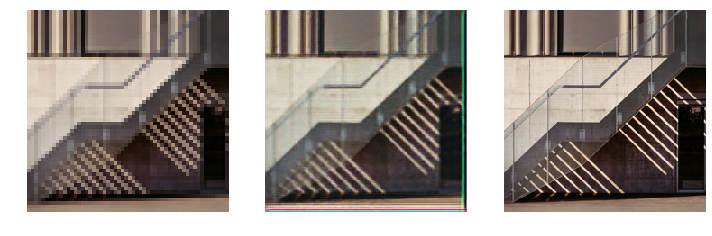

--------------- Epoch 11 ---------------



Dis loss:  8.17486572265625
Gan loss: [0.010165632, 0.008679077, 1.4865545]
--------------- Epoch 12 ---------------



Dis loss:  7.6800031661987305
Gan loss: [0.011305523, 0.009329611, 1.9759114]
--------------- Epoch 13 ---------------



Dis loss:  8.194201469421387
Gan loss: [0.012813657, 0.012012624, 0.801032]
--------------- Epoch 14 ---------------



Dis loss:  8.364347457885742
Gan loss: [0.012363921, 0.011140298, 1.2236228]
--------------- Epoch 15 ---------------



Dis loss:  8.083100318908691
Gan loss: [0.012979859, 0.0113869095, 1.5929493]
--------------- Epoch 16 ---------------



Dis loss:  7.461184501647949
Gan loss: [0.010621837, 0.0085649295, 2.0569077]
--------------- Epoch 17 ---------------



Dis loss:  7.634843826293945
Gan loss: [0.011458344, 0.010012982, 1.4453614]
--------------- Epoch 18 ---------------



Dis loss:  7.948875427246094
Gan loss: [0.0092383, 0.007836238, 1.4020619]
--------------- Epoch 19 ---------------



Dis loss:  8.197447776794434
Gan loss: [0.0119548235, 0.009498735, 2.4560885]
--------------- Epoch 20 ---------------



Dis loss:  8.182276725769043
Gan loss: [0.009380886, 0.007901417, 1.4794694]


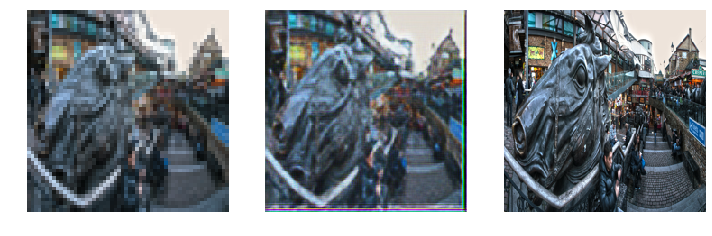

--------------- Epoch 21 ---------------



Dis loss:  8.066410064697266
Gan loss: [0.011275549, 0.010059513, 1.2160363]
--------------- Epoch 22 ---------------



Dis loss:  7.975151538848877
Gan loss: [0.010740901, 0.008418376, 2.3225253]
--------------- Epoch 23 ---------------



Dis loss:  7.481348991394043
Gan loss: [0.0117558455, 0.010025094, 1.7307508]
--------------- Epoch 24 ---------------



Dis loss:  7.898760795593262
Gan loss: [0.009962021, 0.0085661905, 1.3958305]
--------------- Epoch 25 ---------------



Dis loss:  7.99666166305542
Gan loss: [0.009648637, 0.008076248, 1.5723889]
--------------- Epoch 26 ---------------



Dis loss:  7.945736885070801
Gan loss: [0.012337901, 0.010202741, 2.1351593]
--------------- Epoch 27 ---------------



Dis loss:  7.6805243492126465
Gan loss: [0.008887691, 0.007717626, 1.1700652]
--------------- Epoch 28 ---------------



Dis loss:  7.977999687194824
Gan loss: [0.01103143, 0.009235892, 1.7955374]
--------------- Epoch 29 ---------------



Dis loss:  7.8420000076293945
Gan loss: [0.0105519, 0.008513883, 2.0380173]
--------------- Epoch 30 ---------------



Dis loss:  8.34172534942627
Gan loss: [0.0108258175, 0.009390801, 1.4350162]


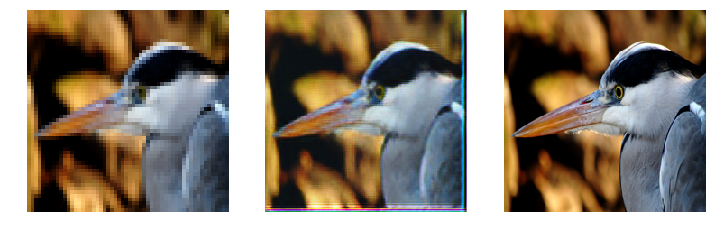

--------------- Epoch 31 ---------------



Dis loss:  7.963836193084717
Gan loss: [0.009411236, 0.0077810693, 1.6301664]
--------------- Epoch 32 ---------------



Dis loss:  7.794416427612305
Gan loss: [0.010840858, 0.008904809, 1.9360493]
--------------- Epoch 33 ---------------



Dis loss:  7.857846260070801
Gan loss: [0.013038898, 0.0118255615, 1.2133366]
--------------- Epoch 34 ---------------



Dis loss:  7.783742904663086
Gan loss: [0.009422883, 0.008337857, 1.0850258]
--------------- Epoch 35 ---------------


In [ ]:
## BEIGN TRAINING
x_tr_hr, x_tr_lr, x_test_hr, x_test_lr = get_images('data', 0.2, 1400)

# saved_generator_apth
gen_path = 'drive/My Drive/Colab Notebooks/AML_SR_GAN_IVR/gen_model50.h5'
# saved discriminator path
dis_path = 'drive/My Drive/Colab Notebooks/AML_SR_GAN_IVR/dis_model50.h5'
# plotted images target directory
save_dir = 'drive/My Drive/Colab Notebooks/AML_SR_GAN_IVR/'

train(500, 8, (x_tr_hr, x_tr_lr, x_test_hr, x_test_lr), save_dir=save_dir, gen_model_path=gen_path, dis_model_path=dis_path)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:92: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


Generator weights updated
Dis model weights updated
219062272/219055592 [==============================] - 3s 0us/step
--------------- Epoch 1 ---------------


Instructions for updating:
Use tf.cast instead.

Dis loss:  8.148310661315918
Gan loss: [0.01799105, 0.016802132, 1.1889169]
--------------- Epoch 2 ---------------



Dis loss:  7.464790344238281
Gan loss: [0.017167525, 0.015910698, 1.2568274]
--------------- Epoch 3 ---------------



Dis loss:  7.88632345199585
Gan loss: [0.019162674, 0.017765405, 1.3972692]
--------------- Epoch 4 ---------------



Dis loss:  7.940842628479004
Gan loss: [0.017202912, 0.015409231, 1.7936802]
--------------- Epoch 5 ---------------



Dis loss:  8.075780868530273
Gan loss: [0.019535096, 0.018025208, 1.509888]
--------------- Epoch 6 ---------------



Dis loss:  7.651192665100098
Gan loss: [0.0149483895, 0.013715942, 1.2324471]
--------------- Epoch 7 ---------------



Dis loss:  7.584657669067383
Gan loss: [0.016347317, 0.014847737, 1.4995809]
--------------- Epoch 8 ---------------



Dis loss:  8.14246940612793
Gan loss: [0.019340731, 0.01751914, 1.8215904]
--------------- Epoch 9 ---------------



Dis loss:  7.892141819000244
Gan loss: [0.017001675, 0.015076878, 1.9247973]
--------------- Epoch 10 ---------------



Dis loss:  7.921557426452637
Gan loss: [0.019131307, 0.01742943, 1.7018756]


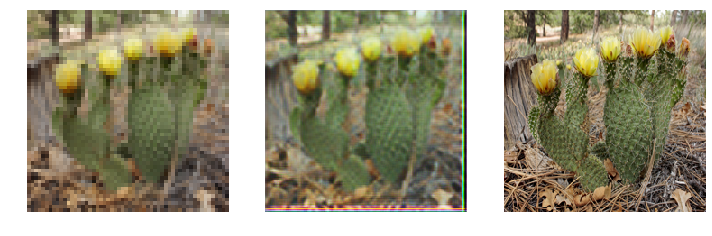

--------------- Epoch 11 ---------------



Dis loss:  8.124999046325684
Gan loss: [0.016968964, 0.015049567, 1.9193964]
--------------- Epoch 12 ---------------



Dis loss:  8.20885181427002
Gan loss: [0.015075388, 0.013536573, 1.5388147]
--------------- Epoch 13 ---------------



Dis loss:  7.778730392456055
Gan loss: [0.01671815, 0.015287235, 1.4309134]
--------------- Epoch 14 ---------------



Dis loss:  7.831778049468994
Gan loss: [0.015898699, 0.013958606, 1.9400927]
--------------- Epoch 15 ---------------



Dis loss:  7.918422698974609
Gan loss: [0.01798259, 0.016046315, 1.9362735]
--------------- Epoch 16 ---------------



Dis loss:  8.27449893951416
Gan loss: [0.015672704, 0.013846498, 1.8262066]
--------------- Epoch 17 ---------------



Dis loss:  8.305192947387695
Gan loss: [0.019374145, 0.017670143, 1.7040018]
--------------- Epoch 18 ---------------



Dis loss:  8.348020553588867
Gan loss: [0.01584379, 0.013879697, 1.9640926]
--------------- Epoch 19 ---------------



Dis loss:  8.318103790283203
Gan loss: [0.015521583, 0.01374344, 1.7781436]
--------------- Epoch 20 ---------------



Dis loss:  7.631397247314453
Gan loss: [0.015958058, 0.014598916, 1.3591409]


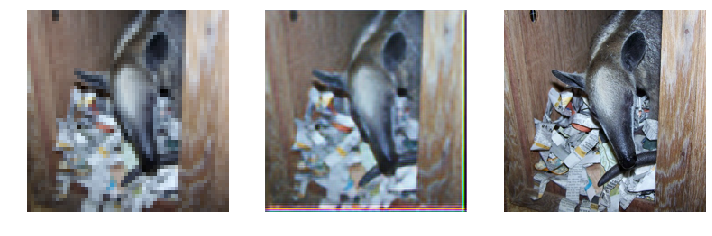

--------------- Epoch 21 ---------------



Dis loss:  7.864512920379639
Gan loss: [0.016180884, 0.014653749, 1.5271355]
--------------- Epoch 22 ---------------



Dis loss:  8.192481994628906
Gan loss: [0.016157376, 0.015320716, 0.8366595]
--------------- Epoch 23 ---------------



Dis loss:  7.798747539520264
Gan loss: [0.015855696, 0.014049867, 1.8058296]
--------------- Epoch 24 ---------------



Dis loss:  7.783928871154785
Gan loss: [0.017067535, 0.015195327, 1.8722081]
--------------- Epoch 25 ---------------



Dis loss:  7.99535608291626
Gan loss: [0.016366238, 0.014354014, 2.0122237]
--------------- Epoch 26 ---------------



Dis loss:  7.918118000030518
Gan loss: [0.014469705, 0.0131372, 1.3325047]
--------------- Epoch 27 ---------------



Dis loss:  8.313959121704102
Gan loss: [0.015340268, 0.013612234, 1.7280339]
--------------- Epoch 28 ---------------



Dis loss:  7.382552146911621
Gan loss: [0.01407982, 0.012935937, 1.143883]
--------------- Epoch 29 ---------------



Dis loss:  8.111099243164062
Gan loss: [0.016545553, 0.014616056, 1.9294964]
--------------- Epoch 30 ---------------



Dis loss:  7.813266277313232
Gan loss: [0.013916521, 0.012311029, 1.6054921]


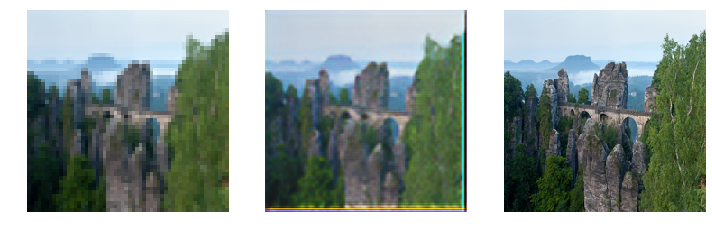

--------------- Epoch 31 ---------------



Dis loss:  7.840330600738525
Gan loss: [0.013603434, 0.01222159, 1.3818446]
--------------- Epoch 32 ---------------



Dis loss:  8.10169506072998
Gan loss: [0.015279483, 0.01332359, 1.9558929]
--------------- Epoch 33 ---------------



Dis loss:  7.786262512207031
Gan loss: [0.015436407, 0.013298391, 2.1380157]
--------------- Epoch 34 ---------------



Dis loss:  7.808926105499268
Gan loss: [0.016060539, 0.014545724, 1.5148147]
--------------- Epoch 35 ---------------



Dis loss:  8.059274673461914
Gan loss: [0.013013582, 0.011605049, 1.4085332]
--------------- Epoch 36 ---------------



Dis loss:  7.810000896453857
Gan loss: [0.018322976, 0.016377475, 1.9455018]
--------------- Epoch 37 ---------------



Dis loss:  7.935211181640625
Gan loss: [0.013222278, 0.01143734, 1.7849382]
--------------- Epoch 38 ---------------



Dis loss:  7.832313537597656
Gan loss: [0.014382696, 0.012792056, 1.5906392]
--------------- Epoch 39 ---------------



Dis loss:  8.019465446472168
Gan loss: [0.014119377, 0.012716959, 1.4024177]
--------------- Epoch 40 ---------------



Dis loss:  7.798879146575928
Gan loss: [0.01434709, 0.012515078, 1.8320117]


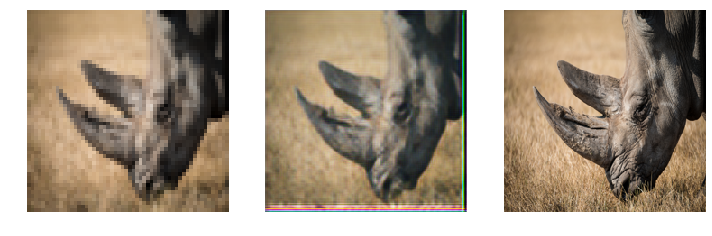

--------------- Epoch 41 ---------------



Dis loss:  7.925157070159912
Gan loss: [0.01621665, 0.014858639, 1.3580109]
--------------- Epoch 42 ---------------



Dis loss:  8.254548072814941
Gan loss: [0.01446497, 0.013416765, 1.0482042]
--------------- Epoch 43 ---------------



Dis loss:  8.424887657165527
Gan loss: [0.014704036, 0.013102, 1.6020355]
--------------- Epoch 44 ---------------



Dis loss:  8.111492156982422
Gan loss: [0.014035504, 0.0120682325, 1.9672718]
--------------- Epoch 45 ---------------



Dis loss:  8.023908615112305
Gan loss: [0.014450672, 0.01288816, 1.5625128]
--------------- Epoch 46 ---------------



Dis loss:  7.947829246520996
Gan loss: [0.014648663, 0.012626652, 2.0220108]
--------------- Epoch 47 ---------------



Dis loss:  7.948186874389648
Gan loss: [0.014712851, 0.01309109, 1.6217607]
--------------- Epoch 48 ---------------



Dis loss:  7.895970344543457
Gan loss: [0.015341918, 0.014058343, 1.2835746]
--------------- Epoch 49 ---------------



Dis loss:  7.889385223388672
Gan loss: [0.014799634, 0.013303877, 1.4957566]
--------------- Epoch 50 ---------------



Dis loss:  8.308517456054688
Gan loss: [0.013556487, 0.01168312, 1.8733664]


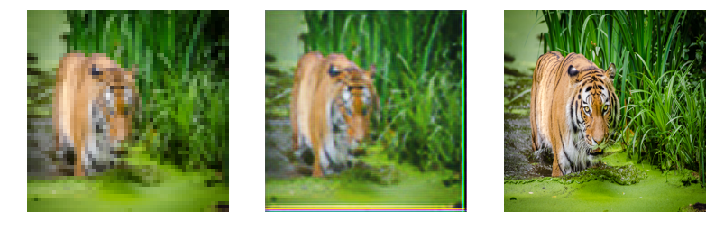

--------------- Epoch 51 ---------------



Dis loss:  7.859170436859131
Gan loss: [0.013885133, 0.012918972, 0.96616024]
--------------- Epoch 52 ---------------



Dis loss:  8.117895126342773
Gan loss: [0.013495653, 0.012083755, 1.4118979]
--------------- Epoch 53 ---------------



Dis loss:  7.7473344802856445
Gan loss: [0.016319003, 0.014713752, 1.6052512]
--------------- Epoch 54 ---------------



Dis loss:  7.962867259979248
Gan loss: [0.012693653, 0.011384786, 1.3088663]
--------------- Epoch 55 ---------------



Dis loss:  7.541923522949219
Gan loss: [0.014252606, 0.012631859, 1.620747]
--------------- Epoch 56 ---------------



Dis loss:  8.010636329650879
Gan loss: [0.0130852675, 0.011933472, 1.1517954]
--------------- Epoch 57 ---------------



Dis loss:  7.828226089477539
Gan loss: [0.015188418, 0.013682784, 1.5056351]
--------------- Epoch 58 ---------------



Dis loss:  8.305948257446289
Gan loss: [0.012873698, 0.011496265, 1.3774326]
--------------- Epoch 59 ---------------



Dis loss:  7.767343521118164
Gan loss: [0.013845383, 0.012014612, 1.8307711]
--------------- Epoch 60 ---------------



Dis loss:  8.256933212280273
Gan loss: [0.015915658, 0.014605343, 1.3103151]


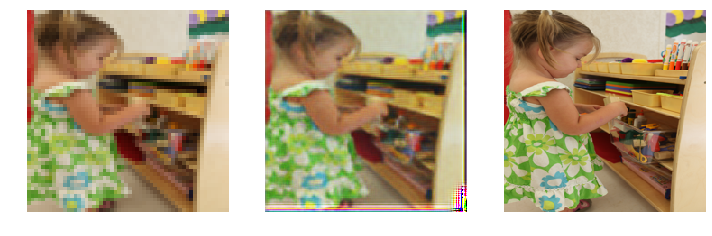

--------------- Epoch 61 ---------------



Dis loss:  7.856841564178467
Gan loss: [0.013888957, 0.011328285, 2.5606718]
--------------- Epoch 62 ---------------



Dis loss:  8.147648811340332
Gan loss: [0.014291665, 0.013020382, 1.2712823]
--------------- Epoch 63 ---------------



Dis loss:  8.454292297363281
Gan loss: [0.014256294, 0.012491577, 1.7647165]
--------------- Epoch 64 ---------------



Dis loss:  7.981748104095459
Gan loss: [0.012325925, 0.010895703, 1.4302218]
--------------- Epoch 65 ---------------



Dis loss:  7.947106838226318
Gan loss: [0.014496328, 0.012548039, 1.94829]
--------------- Epoch 66 ---------------



Dis loss:  7.977628707885742
Gan loss: [0.0132906865, 0.012088871, 1.2018163]
--------------- Epoch 67 ---------------



Dis loss:  8.168814659118652
Gan loss: [0.014389083, 0.013035553, 1.3535305]
--------------- Epoch 68 ---------------



Dis loss:  7.960990905761719
Gan loss: [0.011825198, 0.009990752, 1.8344468]
--------------- Epoch 69 ---------------



Dis loss:  8.032953262329102
Gan loss: [0.011946609, 0.0104077915, 1.5388175]
--------------- Epoch 70 ---------------



Dis loss:  7.83482551574707
Gan loss: [0.014157138, 0.013028935, 1.1282034]


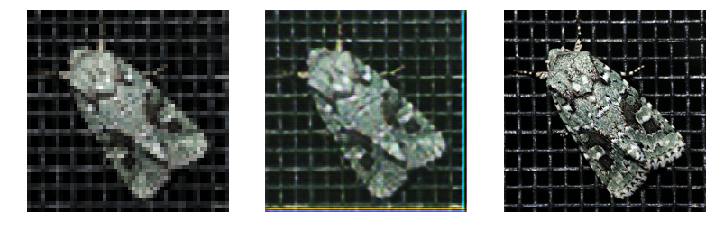

--------------- Epoch 71 ---------------



Dis loss:  7.840002536773682
Gan loss: [0.012000428, 0.010712463, 1.2879645]
--------------- Epoch 72 ---------------



Dis loss:  7.94823694229126
Gan loss: [0.013061078, 0.011674308, 1.38677]
--------------- Epoch 73 ---------------



Dis loss:  7.634965896606445
Gan loss: [0.014309053, 0.012962427, 1.3466265]
--------------- Epoch 74 ---------------



Dis loss:  7.808706283569336
Gan loss: [0.012338588, 0.01094771, 1.3908782]
--------------- Epoch 75 ---------------



Dis loss:  7.9427008628845215
Gan loss: [0.011959262, 0.010405402, 1.5538607]
--------------- Epoch 76 ---------------



Dis loss:  8.041550636291504
Gan loss: [0.011942247, 0.010722439, 1.2198079]
--------------- Epoch 77 ---------------



Dis loss:  8.073083877563477
Gan loss: [0.01406825, 0.0120523805, 2.0158691]
--------------- Epoch 78 ---------------



Dis loss:  7.9109930992126465
Gan loss: [0.014387242, 0.012442624, 1.9446175]
--------------- Epoch 79 ---------------



Dis loss:  8.061614990234375
Gan loss: [0.0166362, 0.01493886, 1.6973392]
--------------- Epoch 80 ---------------



Dis loss:  8.146190643310547
Gan loss: [0.015671209, 0.014136507, 1.5347008]


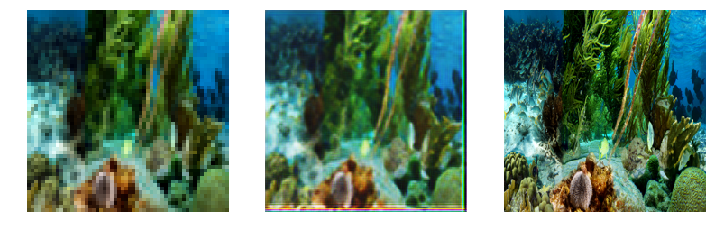

--------------- Epoch 81 ---------------



Dis loss:  8.10554027557373
Gan loss: [0.011670429, 0.0100523885, 1.6180407]
--------------- Epoch 82 ---------------



Dis loss:  8.254054069519043
Gan loss: [0.011881342, 0.010932018, 0.949324]
--------------- Epoch 83 ---------------



Dis loss:  7.593247890472412
Gan loss: [0.01271067, 0.010727407, 1.9832622]
--------------- Epoch 84 ---------------



Dis loss:  7.693234920501709
Gan loss: [0.011958658, 0.010251656, 1.7070016]
--------------- Epoch 85 ---------------



Dis loss:  8.063939094543457
Gan loss: [0.0141712325, 0.012689188, 1.482044]
--------------- Epoch 86 ---------------



Dis loss:  8.152624130249023
Gan loss: [0.01391054, 0.0117123695, 2.1981707]
--------------- Epoch 87 ---------------



Dis loss:  7.841799259185791
Gan loss: [0.011896479, 0.010410318, 1.486161]
--------------- Epoch 88 ---------------



Dis loss:  8.252656936645508
Gan loss: [0.013136456, 0.011228454, 1.9080014]
--------------- Epoch 89 ---------------



Dis loss:  7.762321949005127
Gan loss: [0.011899437, 0.010420874, 1.4785627]
--------------- Epoch 90 ---------------



Dis loss:  7.964170455932617
Gan loss: [0.012571634, 0.0107169775, 1.8546562]


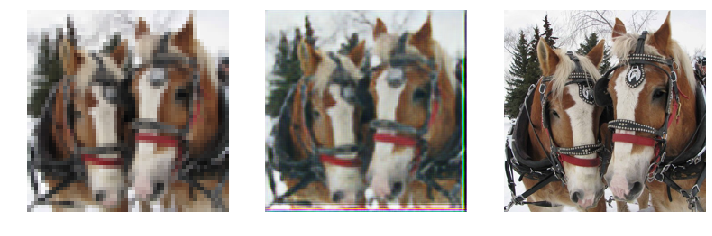

--------------- Epoch 91 ---------------



Dis loss:  8.090667724609375
Gan loss: [0.0121571515, 0.010552431, 1.6047196]
--------------- Epoch 92 ---------------



Dis loss:  7.638945579528809
Gan loss: [0.011902867, 0.010531029, 1.3718379]
--------------- Epoch 93 ---------------



Dis loss:  8.106521606445312
Gan loss: [0.0132924775, 0.011640409, 1.6520686]
--------------- Epoch 94 ---------------



Dis loss:  7.6087727546691895
Gan loss: [0.013808485, 0.01147967, 2.3288145]
--------------- Epoch 95 ---------------



Dis loss:  7.848329544067383
Gan loss: [0.01188993, 0.010433751, 1.4561787]
--------------- Epoch 96 ---------------



Dis loss:  7.787238121032715
Gan loss: [0.012531023, 0.010815947, 1.7150753]
--------------- Epoch 97 ---------------



Dis loss:  8.23542594909668
Gan loss: [0.012339499, 0.011201372, 1.1381264]
--------------- Epoch 98 ---------------



Dis loss:  8.122252464294434
Gan loss: [0.0134450635, 0.0118, 1.6450628]
--------------- Epoch 99 ---------------



Dis loss:  8.042978286743164
Gan loss: [0.012091145, 0.01038007, 1.7110754]
--------------- Epoch 100 ---------------



Dis loss:  7.956719398498535
Gan loss: [0.014429885, 0.012451228, 1.978657]


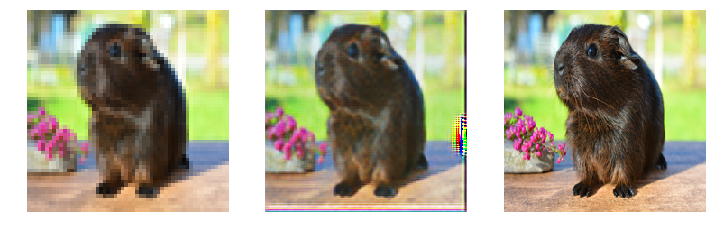

--------------- Epoch 101 ---------------



Dis loss:  8.3606595993042
Gan loss: [0.0124523705, 0.011101848, 1.3505218]
--------------- Epoch 102 ---------------



Dis loss:  7.863210678100586
Gan loss: [0.01275162, 0.011574133, 1.1774871]
--------------- Epoch 103 ---------------



Dis loss:  7.896454334259033
Gan loss: [0.012475234, 0.011082005, 1.39323]
--------------- Epoch 104 ---------------



Dis loss:  8.684659957885742
Gan loss: [0.012829323, 0.011655904, 1.1734188]
--------------- Epoch 105 ---------------



Dis loss:  7.8861894607543945
Gan loss: [0.011619475, 0.010076545, 1.5429296]
--------------- Epoch 106 ---------------



Dis loss:  7.693053722381592
Gan loss: [0.012523016, 0.011063357, 1.4596593]
--------------- Epoch 107 ---------------



Dis loss:  7.954169273376465
Gan loss: [0.0136819035, 0.0118665565, 1.8153472]
--------------- Epoch 108 ---------------



Dis loss:  8.128419876098633
Gan loss: [0.011645577, 0.010528595, 1.1169817]
--------------- Epoch 109 ---------------



Dis loss:  7.678994178771973
Gan loss: [0.011883458, 0.0101771075, 1.7063508]
--------------- Epoch 110 ---------------



Dis loss:  8.02507209777832
Gan loss: [0.012510952, 0.010822795, 1.6881561]


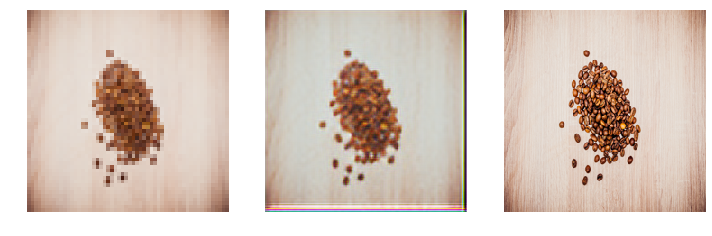

--------------- Epoch 111 ---------------



Dis loss:  7.317992210388184
Gan loss: [0.012741381, 0.011283434, 1.4579474]
--------------- Epoch 112 ---------------



Dis loss:  8.185859680175781
Gan loss: [0.012660736, 0.010798414, 1.862322]
--------------- Epoch 113 ---------------



Dis loss:  8.133832931518555
Gan loss: [0.0125646535, 0.01031548, 2.2491732]
--------------- Epoch 114 ---------------



Dis loss:  8.14493179321289
Gan loss: [0.011603758, 0.009786879, 1.8168792]
--------------- Epoch 115 ---------------



Dis loss:  8.339611053466797
Gan loss: [0.014793933, 0.012974434, 1.8194996]
--------------- Epoch 116 ---------------



Dis loss:  7.960528373718262
Gan loss: [0.012380997, 0.01097556, 1.4054363]
--------------- Epoch 117 ---------------



Dis loss:  7.819045543670654
Gan loss: [0.012389206, 0.010213386, 2.1758199]
--------------- Epoch 118 ---------------



Dis loss:  8.027305603027344
Gan loss: [0.011158846, 0.009027073, 2.1317732]
--------------- Epoch 119 ---------------



Dis loss:  8.375883102416992
Gan loss: [0.012590087, 0.010825149, 1.7649378]
--------------- Epoch 120 ---------------



Dis loss:  8.020848274230957
Gan loss: [0.012652024, 0.010956719, 1.6953049]


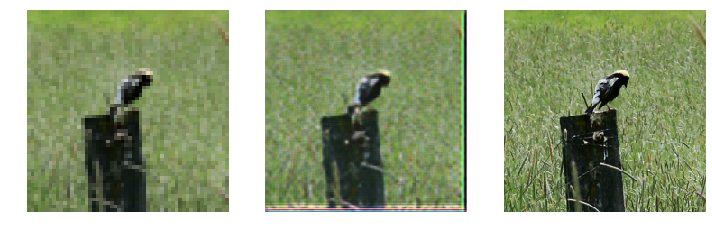

--------------- Epoch 121 ---------------



Dis loss:  8.39696216583252
Gan loss: [0.010816254, 0.0091730775, 1.6431766]
--------------- Epoch 122 ---------------



Dis loss:  7.906919479370117
Gan loss: [0.012844208, 0.011637899, 1.2063084]
--------------- Epoch 123 ---------------



Dis loss:  8.002423286437988
Gan loss: [0.010407335, 0.009091152, 1.3161829]
--------------- Epoch 124 ---------------



Dis loss:  8.218392372131348
Gan loss: [0.014180785, 0.011892488, 2.2882965]
--------------- Epoch 125 ---------------



Dis loss:  7.8573760986328125
Gan loss: [0.011307655, 0.0094819, 1.8257543]
--------------- Epoch 126 ---------------



Dis loss:  7.938101768493652
Gan loss: [0.01660675, 0.015187214, 1.4195354]
--------------- Epoch 127 ---------------



Dis loss:  7.95847749710083
Gan loss: [0.010820389, 0.009228057, 1.592331]
--------------- Epoch 128 ---------------



Dis loss:  8.01435661315918
Gan loss: [0.012126414, 0.010502695, 1.6237189]
--------------- Epoch 129 ---------------



Dis loss:  7.554459571838379
Gan loss: [0.0132372985, 0.010976062, 2.2612362]
--------------- Epoch 130 ---------------



Dis loss:  8.076268196105957
Gan loss: [0.011902311, 0.0107743945, 1.1279163]


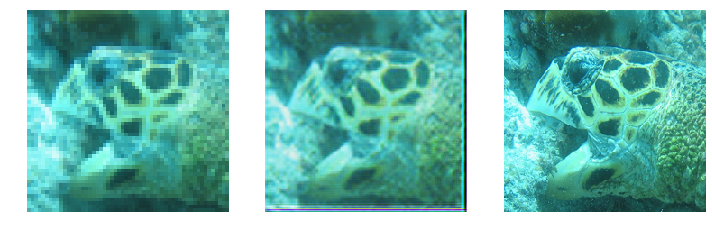

--------------- Epoch 131 ---------------



Dis loss:  7.891422271728516
Gan loss: [0.010772568, 0.009385322, 1.387246]
--------------- Epoch 132 ---------------



Dis loss:  7.71656608581543
Gan loss: [0.012561102, 0.010770341, 1.790761]
--------------- Epoch 133 ---------------



Dis loss:  7.5175395011901855
Gan loss: [0.012130046, 0.010135937, 1.9941097]
--------------- Epoch 134 ---------------



Dis loss:  8.059913635253906
Gan loss: [0.014854295, 0.013040113, 1.8141814]
--------------- Epoch 135 ---------------



Dis loss:  7.8742876052856445
Gan loss: [0.011609981, 0.010350705, 1.2592762]
--------------- Epoch 136 ---------------



Dis loss:  7.8171000480651855
Gan loss: [0.013469806, 0.011428885, 2.0409207]
--------------- Epoch 137 ---------------



Dis loss:  7.943551063537598
Gan loss: [0.012956744, 0.011054151, 1.9025931]
--------------- Epoch 138 ---------------



Dis loss:  7.981391429901123
Gan loss: [0.012012296, 0.010164456, 1.8478402]
--------------- Epoch 139 ---------------



Dis loss:  8.115021705627441
Gan loss: [0.012349713, 0.011086893, 1.2628193]
--------------- Epoch 140 ---------------



Dis loss:  8.066544532775879
Gan loss: [0.011617439, 0.009807538, 1.8099008]


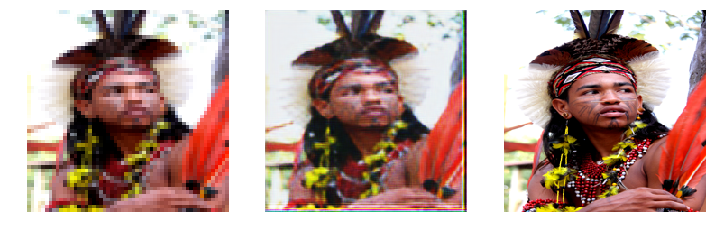

--------------- Epoch 141 ---------------



Dis loss:  8.134108543395996
Gan loss: [0.011208502, 0.010365158, 0.84334326]
--------------- Epoch 142 ---------------



Dis loss:  7.616098403930664
Gan loss: [0.009934257, 0.008793457, 1.1407995]
--------------- Epoch 143 ---------------



Dis loss:  7.875765800476074
Gan loss: [0.011225236, 0.009709101, 1.5161347]
--------------- Epoch 144 ---------------



Dis loss:  8.446586608886719
Gan loss: [0.012811237, 0.01086511, 1.9461266]
--------------- Epoch 145 ---------------



Dis loss:  7.977636337280273
Gan loss: [0.011118703, 0.009841366, 1.2773364]
--------------- Epoch 146 ---------------



Dis loss:  7.994030952453613
Gan loss: [0.010850572, 0.009163879, 1.686693]
--------------- Epoch 147 ---------------



Dis loss:  8.107123374938965
Gan loss: [0.0130972685, 0.011458851, 1.6384168]
--------------- Epoch 148 ---------------



Dis loss:  8.022937774658203
Gan loss: [0.010689331, 0.008786982, 1.9023495]
--------------- Epoch 149 ---------------



Dis loss:  7.862907886505127
Gan loss: [0.01194415, 0.010005596, 1.9385535]
--------------- Epoch 150 ---------------



Dis loss:  7.988433837890625
Gan loss: [0.011412566, 0.009825991, 1.5865748]


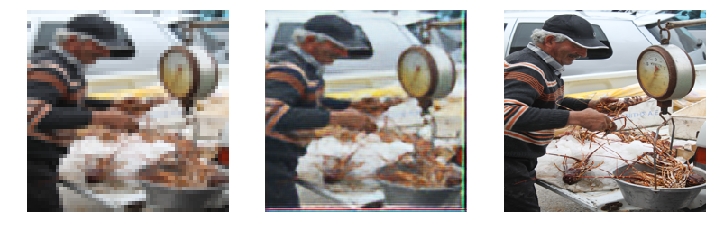

--------------- Epoch 151 ---------------



Dis loss:  7.768543720245361
Gan loss: [0.011301985, 0.00973942, 1.5625648]
--------------- Epoch 152 ---------------



Dis loss:  8.263664245605469
Gan loss: [0.011253864, 0.009597421, 1.6564425]
--------------- Epoch 153 ---------------



Dis loss:  7.788025856018066
Gan loss: [0.01195648, 0.010445823, 1.5106574]
--------------- Epoch 154 ---------------



Dis loss:  8.327268600463867
Gan loss: [0.010695426, 0.0085547585, 2.140667]
--------------- Epoch 155 ---------------



Dis loss:  8.278448104858398
Gan loss: [0.010382966, 0.009093138, 1.2898273]
--------------- Epoch 156 ---------------



Dis loss:  8.59813117980957
Gan loss: [0.0109071825, 0.008736703, 2.1704793]
--------------- Epoch 157 ---------------



Dis loss:  7.618070125579834
Gan loss: [0.011050524, 0.009444858, 1.6056659]
--------------- Epoch 158 ---------------



Dis loss:  7.328181743621826
Gan loss: [0.010727214, 0.008640618, 2.0865953]
--------------- Epoch 159 ---------------



Dis loss:  7.972908973693848
Gan loss: [0.011756909, 0.010567096, 1.1898131]
--------------- Epoch 160 ---------------



Dis loss:  8.256680488586426
Gan loss: [0.012136852, 0.010088924, 2.0479279]


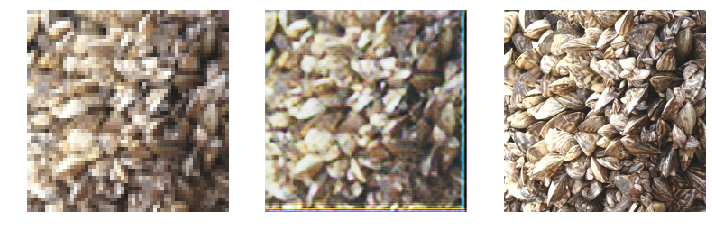

--------------- Epoch 161 ---------------



Dis loss:  7.651595115661621
Gan loss: [0.011531027, 0.010000054, 1.5309728]
--------------- Epoch 162 ---------------



Dis loss:  8.06155014038086
Gan loss: [0.011097796, 0.009146425, 1.951371]
--------------- Epoch 163 ---------------



Dis loss:  7.759346961975098
Gan loss: [0.009915106, 0.008139444, 1.7756624]
--------------- Epoch 164 ---------------



Dis loss:  7.975333213806152
Gan loss: [0.011444397, 0.009933064, 1.511334]
--------------- Epoch 165 ---------------



Dis loss:  8.0323486328125
Gan loss: [0.013148441, 0.011778302, 1.3701392]
--------------- Epoch 166 ---------------



Dis loss:  8.069572448730469
Gan loss: [0.013538495, 0.01200656, 1.531934]
--------------- Epoch 167 ---------------



Dis loss:  7.780132293701172
Gan loss: [0.012568319, 0.010873772, 1.6945474]
--------------- Epoch 168 ---------------



Dis loss:  8.091109275817871
Gan loss: [0.010353314, 0.008973033, 1.3802807]
--------------- Epoch 169 ---------------



Dis loss:  8.18989372253418
Gan loss: [0.011756276, 0.009921125, 1.8351508]
--------------- Epoch 170 ---------------



Dis loss:  8.174492835998535
Gan loss: [0.01143364, 0.010168507, 1.2651331]


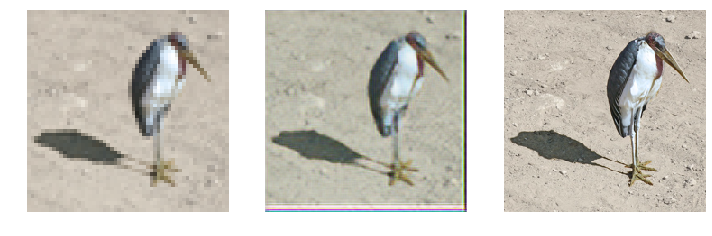

--------------- Epoch 171 ---------------



Dis loss:  8.010814666748047
Gan loss: [0.011379501, 0.009546546, 1.8329545]
--------------- Epoch 172 ---------------



Dis loss:  8.148900985717773
Gan loss: [0.011057125, 0.008980508, 2.0766168]
--------------- Epoch 173 ---------------



Dis loss:  7.93524694442749
Gan loss: [0.011950791, 0.010086032, 1.8647594]
--------------- Epoch 174 ---------------



Dis loss:  8.1930570602417
Gan loss: [0.011056732, 0.0097279055, 1.3288271]
--------------- Epoch 175 ---------------



Dis loss:  7.922703742980957
Gan loss: [0.010899502, 0.008826424, 2.0730774]
--------------- Epoch 176 ---------------



Dis loss:  7.798116207122803
Gan loss: [0.010859601, 0.00945309, 1.4065113]
--------------- Epoch 177 ---------------



Dis loss:  8.131877899169922
Gan loss: [0.010247793, 0.008466153, 1.7816395]
--------------- Epoch 178 ---------------



Dis loss:  8.081356048583984
Gan loss: [0.01024013, 0.008483579, 1.7565508]
--------------- Epoch 179 ---------------



Dis loss:  8.056772232055664
Gan loss: [0.011415186, 0.010005694, 1.4094924]
--------------- Epoch 180 ---------------



Dis loss:  7.909807205200195
Gan loss: [0.013654022, 0.011388129, 2.2658925]


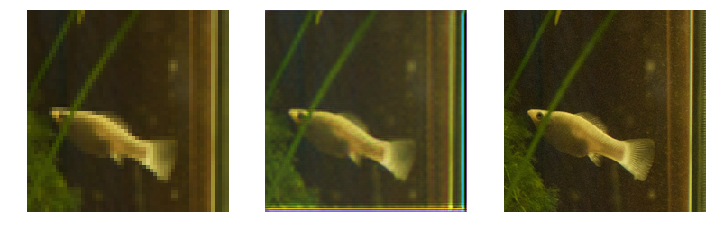

--------------- Epoch 181 ---------------



Dis loss:  7.738777160644531
Gan loss: [0.010394687, 0.008524804, 1.8698823]
--------------- Epoch 182 ---------------



Dis loss:  7.968008518218994
Gan loss: [0.009486516, 0.008042488, 1.4440274]
--------------- Epoch 183 ---------------



Dis loss:  7.701173305511475
Gan loss: [0.010888886, 0.009552908, 1.3359773]
--------------- Epoch 184 ---------------



Dis loss:  7.868800640106201
Gan loss: [0.010788126, 0.0090616895, 1.7264363]
--------------- Epoch 185 ---------------



Dis loss:  7.762624263763428
Gan loss: [0.009591651, 0.008550263, 1.041388]
--------------- Epoch 186 ---------------



Dis loss:  8.374217987060547
Gan loss: [0.012127631, 0.010831835, 1.2957962]
--------------- Epoch 187 ---------------



Dis loss:  8.043968200683594
Gan loss: [0.010457154, 0.008668685, 1.7884691]
--------------- Epoch 188 ---------------



Dis loss:  7.776866912841797
Gan loss: [0.012174708, 0.010473512, 1.7011954]
--------------- Epoch 189 ---------------



Dis loss:  8.186117172241211
Gan loss: [0.011464168, 0.010110695, 1.3534734]
--------------- Epoch 190 ---------------



Dis loss:  8.487338066101074
Gan loss: [0.010956665, 0.009163973, 1.7926917]


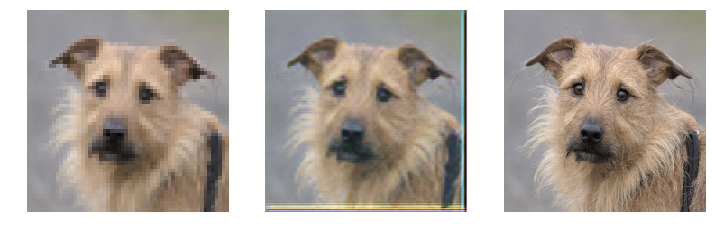

--------------- Epoch 191 ---------------



Dis loss:  7.7402238845825195
Gan loss: [0.011351583, 0.009281201, 2.0703812]
--------------- Epoch 192 ---------------



Dis loss:  7.769258499145508
Gan loss: [0.010033307, 0.00859545, 1.4378564]
--------------- Epoch 193 ---------------



Dis loss:  7.964987754821777
Gan loss: [0.0104199, 0.008872147, 1.5477531]
--------------- Epoch 194 ---------------



Dis loss:  7.854048728942871
Gan loss: [0.010189275, 0.008812558, 1.3767171]
--------------- Epoch 195 ---------------



Dis loss:  8.014050483703613
Gan loss: [0.011316695, 0.009988308, 1.3283875]
--------------- Epoch 196 ---------------



Dis loss:  7.896242141723633
Gan loss: [0.010419174, 0.009192098, 1.2270763]
--------------- Epoch 197 ---------------



Dis loss:  7.8166704177856445
Gan loss: [0.012824863, 0.01113188, 1.6929833]
--------------- Epoch 198 ---------------



Dis loss:  7.758662223815918
Gan loss: [0.0103063295, 0.008762975, 1.5433539]
--------------- Epoch 199 ---------------



Dis loss:  7.9148054122924805
Gan loss: [0.009479364, 0.007903095, 1.5762694]
--------------- Epoch 200 ---------------



Dis loss:  7.545958518981934
Gan loss: [0.01125522, 0.009954605, 1.3006144]


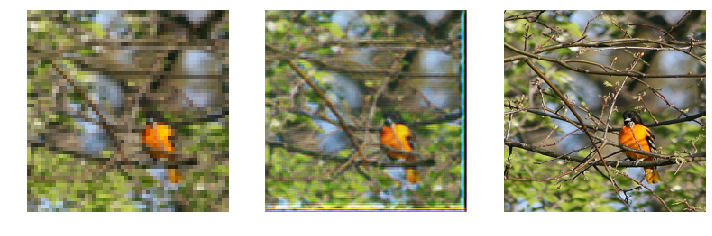

--------------- Epoch 201 ---------------



Dis loss:  7.852427005767822
Gan loss: [0.011217352, 0.009582759, 1.6345934]
--------------- Epoch 202 ---------------



Dis loss:  8.22482681274414
Gan loss: [0.010450756, 0.009268555, 1.1822013]
--------------- Epoch 203 ---------------



Dis loss:  7.429449081420898
Gan loss: [0.010709584, 0.009161681, 1.5479031]
--------------- Epoch 204 ---------------



Dis loss:  7.5695295333862305
Gan loss: [0.010353573, 0.009156535, 1.1970375]
--------------- Epoch 205 ---------------



Dis loss:  7.6252241134643555
Gan loss: [0.010775528, 0.009807701, 0.96782637]
--------------- Epoch 206 ---------------



Dis loss:  7.957003593444824
Gan loss: [0.011423253, 0.009399484, 2.0237691]
--------------- Epoch 207 ---------------



Dis loss:  7.762735366821289
Gan loss: [0.012151412, 0.010306334, 1.8450774]
--------------- Epoch 208 ---------------



Dis loss:  7.787169456481934
Gan loss: [0.011381475, 0.010091828, 1.2896473]
--------------- Epoch 209 ---------------



Dis loss:  7.66351842880249
Gan loss: [0.01038074, 0.009338744, 1.041996]
--------------- Epoch 210 ---------------


Buffered data was truncated after reaching the output size limit.

In [11]:
## BEIGN TRAINING
x_tr_hr, x_tr_lr, x_test_hr, x_test_lr = get_images('data', 0.2, 1400)

# saved_generator_apth
gen_path = 'drive/My Drive/Colab Notebooks/AML_SR_GAN_IVR/gen_model100.h5'
# saved discriminator path
dis_path = 'drive/My Drive/Colab Notebooks/AML_SR_GAN_IVR/dis_model100.h5'
# plotted images target directory
save_dir = 'drive/My Drive/Colab Notebooks/AML_SR_GAN_IVR/'

train(500, 8, (x_tr_hr, x_tr_lr, x_test_hr, x_test_lr), save_dir=save_dir, gen_model_path=gen_path, dis_model_path=dis_path)

## Run Below Block to Generate Images using pre-trained weights file



*   Pass path of the generator, default is the root directory of code



In [7]:
# trying to laod the save model
from keras.models import load_model
# total run as of yet 400
# plotting on 50 eps for reprt
# gen_path = "drive/My Drive/Colab Notebooks/AML_SR_GAN_IVR/gen_model500.h5"
gen_path = "gen_model1000.h5"
gen = create_generator((56, 56, 3))

gen.load_weights(gen_path)

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("ac...)`


# Plot the test Images from above generator


*   Pass the path of target_dir, where generated images are saved
*   Pass the path of test_img dir, where the iamges to be tested are stored



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:102: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.


4  images read from:  drive/My Drive/Colab Notebooks/AML_SR_GAN/gen_image_After_1000/report_iamges
(4, 224, 224, 3)


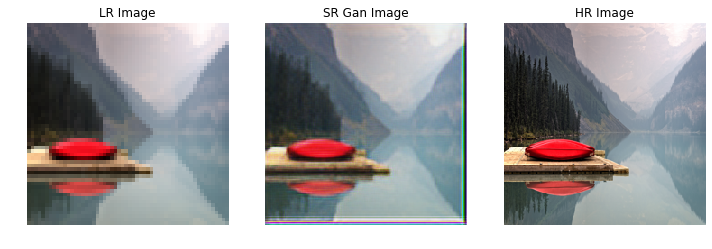

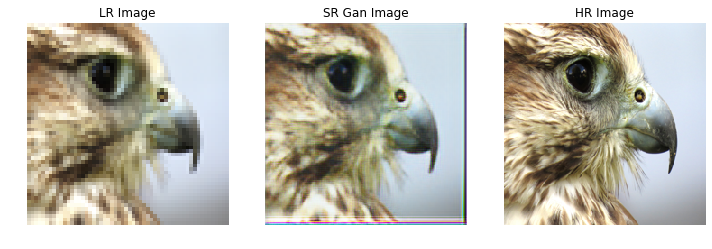

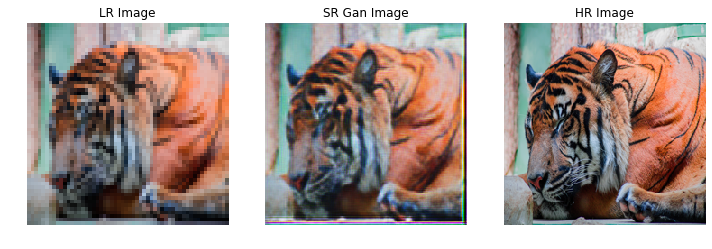

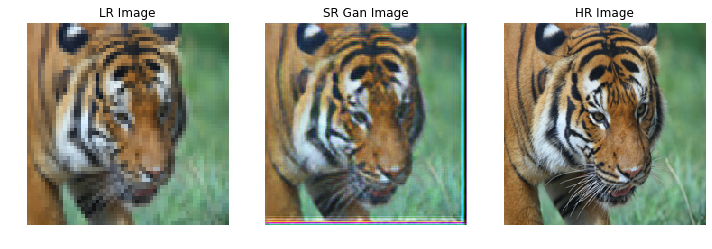

In [8]:
# create photos from this if possible
# x_tr_hr, x_tr_lr, x_test_hr, x_test_lr = get_images('data', 0.2, 100)
img_dir = "../report_images"
save_dir = "gen_images"
plot_all_images(gen, target_path, img_dir=test_images_path)